# Housing Regression Maching Learning Project

### Imports (Data and Packages)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from data_preprocessing_final import cleaning, dummify_func
from sklearn.preprocessing import StandardScaler, MinMaxScaler
%matplotlib inline 

In [2]:
housing = pd.read_csv('./data/Ames_Housing_Price_Data.csv', index_col=0)
housing = housing[housing['SaleCondition'] == 'Normal']
real_estate = pd.read_csv('./data/Ames_Real_Estate_data.csv' , index_col = 0)

C:\Users\jackc\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (36,40,81,87) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
housing = cleaning(housing)
input, target = dummify_func(housing)
target = np.log(target)

In [4]:
input.shape

(2413, 324)

### EDA

In [5]:
## See correlations related to sale price and to eyeball which features might matter the most 
corrs = housing.corr()
highly_correlated = corrs[np.abs(corrs['SalePrice']) >= .6]
medium_correlated = corrs[np.abs(corrs['SalePrice']).between(.4,.6)] 
low_correlated = corrs[(np.abs(corrs['SalePrice']) < .4)] 

## Print out column headers that are going to have high and medium correlations to sales price 
print('Highly correlated variables are: ')
print(highly_correlated['SalePrice'])
print('-'*150)
print('Medium correlated variables are: ')
print(medium_correlated['SalePrice'])
print('-'*150)
print('Low correlated variables are: ')
print(low_correlated['SalePrice'])

Highly correlated variables are: 
GrLivArea      0.736040
SalePrice      1.000000
OverallQual    0.787266
TotalBsmtSF    0.642555
1stFlrSF       0.634755
GarageCars     0.632217
GarageArea     0.621855
Name: SalePrice, dtype: float64
------------------------------------------------------------------------------------------------------------------------------------------------------
Medium correlated variables are: 
YearBuilt       0.533163
YearRemodAdd    0.501543
MasVnrArea      0.486528
BsmtFinSF1      0.454164
FullBath        0.548532
TotRmsAbvGrd    0.496571
Fireplaces      0.493448
GarageYrBlt     0.492190
Name: SalePrice, dtype: float64
------------------------------------------------------------------------------------------------------------------------------------------------------
Low correlated variables are: 
PID             -0.207391
MSSubClass      -0.075707
LotFrontage      0.344709
LotArea          0.275087
OverallCond     -0.091298
BsmtFinSF2       0.038297
BsmtUnfSF  

### Start dummifying variables and look at multicollinearity

In [6]:
## Identify Categorical Variables and create a list of them (With PID included so we can use as key later on)
category_list = list(housing.select_dtypes('object').columns)
category_list.append('PID')

## Use the list above to create a dataframe with just the categorical variables and PID
category_variables = housing[housing.columns.intersection(category_list)]

## Dummify the categorical variables
category = pd.get_dummies(data = category_variables, prefix_sep = '_' , drop_first=True)

## Remove the original categorical values from the dataframe and merge the dummified and original values into a new dataframe called final
housing.drop(columns = housing.select_dtypes('object').columns, axis =1, inplace=True)
final = pd.merge(housing, category, on = 'PID')


## Begin work on Lasso Regression

In [7]:
## Working on Lasso Regression
from sklearn.linear_model import Lasso
lasso = Lasso()

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(input,target,test_size=0.2)

In [9]:
## Find the right Alpha 

train_R2 = []
test_R2  = []
alphaRange = np.linspace(0,0.002,100)
for alpha in alphaRange:
    lasso.set_params(alpha=alpha, normalize=True, max_iter=2000)  
    lasso.fit(X_train, Y_train)
    train_R2.append(lasso.score(X_train, Y_train))
    test_R2.append(lasso.score(X_test, Y_test))

<ipython-input-9-a55a3e30f199>:8: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(X_train, Y_train)
C:\Users\jackc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\jackc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.779673269707759, tolerance: 0.026704140887489087
  model = cd_fast.enet_coordinate_descent(


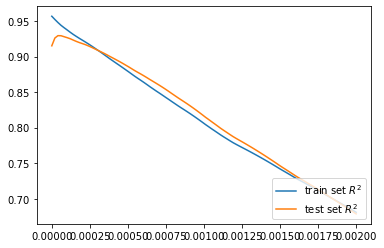

In [10]:
# Plot the train R2 and test R2 to see where they intersect

plt.plot(alphaRange, train_R2, label=r'train set $R^2$')
plt.plot(alphaRange, test_R2, label=r'test set $R^2$')
plt.legend(loc=4)

In [36]:
#With alpha set to .012, use the lasso model

lasso.set_params(alpha=.00025, normalize=False)
lasso.fit(input, target)
print('The intercept is %.4f' %(lasso.intercept_))
lassoCoef = pd.Series(lasso.coef_, index=input.columns)
print('The slopes are %s' %(lassoCoef))

The intercept is 4.8318
The slopes are PID                         6.865322e-11
GrLivArea                   3.728199e-04
LotArea                     2.357709e-06
YearBuilt                   2.325735e-03
YearRemodAdd                8.785399e-04
1stFlrSF                    2.306444e-05
2ndFlrSF                   -7.041906e-05
LowQualFinSF               -2.000494e-04
FullBath                    1.325064e-02
HalfBath                    1.236340e-02
BedroomAbvGr               -1.042511e-02
KitchenAbvGr               -4.342131e-02
TotRmsAbvGrd               -5.113190e-04
Fireplaces                  2.262285e-02
WoodDeckSF                  6.873336e-05
OpenPorchSF                 1.231064e-04
EnclosedPorch               1.546652e-04
3SsnPorch                   1.159720e-04
ScreenPorch                 2.509990e-04
PoolArea                   -1.931077e-05
MSZoning_C (all)           -7.757232e-02
MSZoning_FV                 2.677807e-02
MSZoning_I (all)           -0.000000e+00
MSZoning_RH       

C:\Users\jackc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.7152675879539, tolerance: 0.033174697901983054
  model = cd_fast.enet_coordinate_descent(


In [37]:
lasso_pd = pd.DataFrame(lassoCoef)

In [38]:
lasso_pd.reset_index(inplace=True)
lasso_pd.columns = ['Feature', 'Lasso_coef']

In [39]:
lasso_pd.sort_values(by = ['Lasso_coef'], ascending=False)

,Feature,Lasso_coef
260,OverallQual_10,2.687553e-01
268,OverallQual_9,2.542504e-01
51,Neighborhood_GrnHill,1.848116e-01
267,OverallQual_8,1.388224e-01
65,Neighborhood_Somerst,9.338707e-02
276,OverallCond_9,8.706477e-02
47,Neighborhood_Crawfor,8.635106e-02
198,Functional_Typ,7.317137e-02
266,OverallQual_7,6.761229e-02
275,OverallCond_8,6.731816e-02


In [40]:
print('Training = ', lasso.score(X_train, Y_train))
print('Testing = ', lasso.score(X_test, Y_test))

Training =  0.9435129106338533
Testing =  0.9472853345662671


In [34]:
features_removed = lasso_pd[lasso_pd['Lasso_coef'] == 0]
features_removed.shape

(122, 2)

In [35]:
features_removed

,Feature,Lasso_coef
22,MSZoning_I (all),-0.0
25,MSZoning_RM,-0.0
26,Street_Pave,0.0
28,Alley_Pave,0.0
35,Utilities_NoSewr,-0.0
38,LotConfig_FR3,-0.0
39,LotConfig_Inside,-0.0
43,Neighborhood_BrDale,0.0
49,Neighborhood_Gilbert,-0.0
52,Neighborhood_IDOTRR,-0.0
